# Page to Page Journey Analysis

This notebook attempts various algorithms for finding fruadulent activity in the web-site. One of them is a page to page user traverals on the site.

In [1]:
!pip install pydot

You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Read Data From Redshift

Collect page loads information

In [2]:
#Read Redshift credentials
import boto3
import base64
from botocore.exceptions import ClientError
import ast

def get_secret():

    secret_name = "GBRedshiftSecret"
    region_name = "us-east-2"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    # In this sample we only handle the specific exceptions for the 'GetSecretValue' API.
    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    # We rethrow the exception by default.

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        if e.response['Error']['Code'] == 'DecryptionFailureException':
            # Secrets Manager can't decrypt the protected secret text using the provided KMS key.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InternalServiceErrorException':
            # An error occurred on the server side.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InvalidParameterException':
            # You provided an invalid value for a parameter.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InvalidRequestException':
            # You provided a parameter value that is not valid for the current state of the resource.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'ResourceNotFoundException':
            # We can't find the resource that you asked for.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
    else:
          # Decrypts secret using the associated KMS CMK.
        # Depending on whether the secret is a string or binary, one of these fields will be populated.
        if 'SecretString' in get_secret_value_response:
            secret = get_secret_value_response['SecretString']
            return(secret)
        else:
            decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
            return(decode_binary_secret)

secret = get_secret()
USER = ast.literal_eval(secret)['username']
PASSWORD = ast.literal_eval(secret)['password']
HOST = ast.literal_eval(secret)['host']

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from networkx.drawing.nx_pydot import graphviz_layout
import psycopg2
import time

warnings.filterwarnings('ignore')
url_string = f"dbname='prod' port=5439 user='{USER}' password='{PASSWORD}' host='{HOST}'"
con = psycopg2.connect(url_string)
print(time.ctime(), "Redshift connection Successful!")
cur = con.cursor()

#We assign different groups for different page (based on the purpose if this page) in order to assign different colors.
sqlmsg = "select session_uuid, hit_ts, \
          (case when (page_title like '%Alcatel%' or page_title like '%ALCATEL%' or page_title like '%ZTE%' or page_title like '%iPhone%' or page_title like '%Samsung%' or page_title like '%LG %' or page_title like '%Phones%' or page_title like '%Net10%') then 'Phones' \
                           when page_title like '%Checkout%' then 'Checkout' \
                           when page_title like '%404%' then 'Error' \
                           when (page_title like '%Activa%' or page_title like '%Airtime%' or page_title like '%AIRTIME%' or page_title like '%Min%' or page_title like '%Prepaid%') then 'Recharge' \
                           when (page_title like '%Charger%' or page_title like '%Cable%' or page_title like '%Speaker%' or page_title like '%Accesso%' or page_title like '%Bluetoo%' or page_title like '%USB%') then 'Accessories' \
                           when (page_title like '%Plan%' or page_title like '%plan%' or page_title like '%Unlimited%') then 'Buy Plan' \
                           when page_title like '%Refill%' then 'Refill' \
                           when (page_title like '%Balance%' or page_title like '%Account%' or page_title like '%Log%') then 'Balance' \
                           when (page_title like '%Contact%' or page_title like '%pedido%' or page_title like '%Support%' or page_title like '%Service%' or page_title like '%Why%') then 'Support' \
                           when page_title like '%GoSmart Mobile%' then 'GoSmart Mobile' \
                           when (page_title like '%About%' or page_title like '%Term%') then 'About' \
                           when page_title like '%Card%' then 'Card' \
                           when page_title like '%Rewards%' then 'Rewards' \
                           when (page_title like '%StraighTalk%' or page_title like '%Straight Talk%') then 'StraightTalk' \
                           else 'Other' end) as uri \
          from page_loads_tf \
          limit 10000;"
cur.execute(sqlmsg)
data = pd.DataFrame(cur.fetchall(), columns=['session_uuid', 'action_ts', 'uri'])

Tue Aug 13 14:41:39 2019 Redshift connection Successful!


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Build the Links

Create links between consecutives pages in the same session.

In [4]:
#Clean non-ASCII characters
data['uri'] = data["uri"].apply(lambda x: ''.join(["" if ord(i) < 32 or ord(i) > 126 else i for i in x]))
data2 = data.sort_values(['session_uuid', 'action_ts'])
data2 = data2.reset_index().drop('index',1)
data2.replace(' ', 'Unknown', inplace=True)

# Calcalate for each row the next page visited
data2['prev_uri'] = data2.groupby('session_uuid').uri.shift(1).fillna('referrer')

## Build The Graph of Links For Visualization

In [5]:
# nodes is: name(str) | group(int) | node size(float)
# links is: source(str) | target(str) | value (float)
nodes = data2.groupby(['uri']).size().reset_index()
nodes['group'] = nodes.index
nodes.columns = ['name', 'nodesize', 'group']
nodes = nodes.append({'name':'referrer', 'nodesize':len(data.session_uuid.unique()), 'group':15}, ignore_index=True)
links = data2.groupby(['uri', 'prev_uri']).size().reset_index()
links.columns = ['source', 'target', 'value']

#G = nx.Graph(day="Stackoverflow")
G = nx.DiGraph()
for index, row in nodes.iterrows():
       G.add_node(row['name'], group=row['group'], nodesize=row['nodesize'])
#G.remove_node(0)

for index, row in links.iterrows():
       G.add_weighted_edges_from([(row['source'], row['target'], row['value'])])


## Plot The Graph

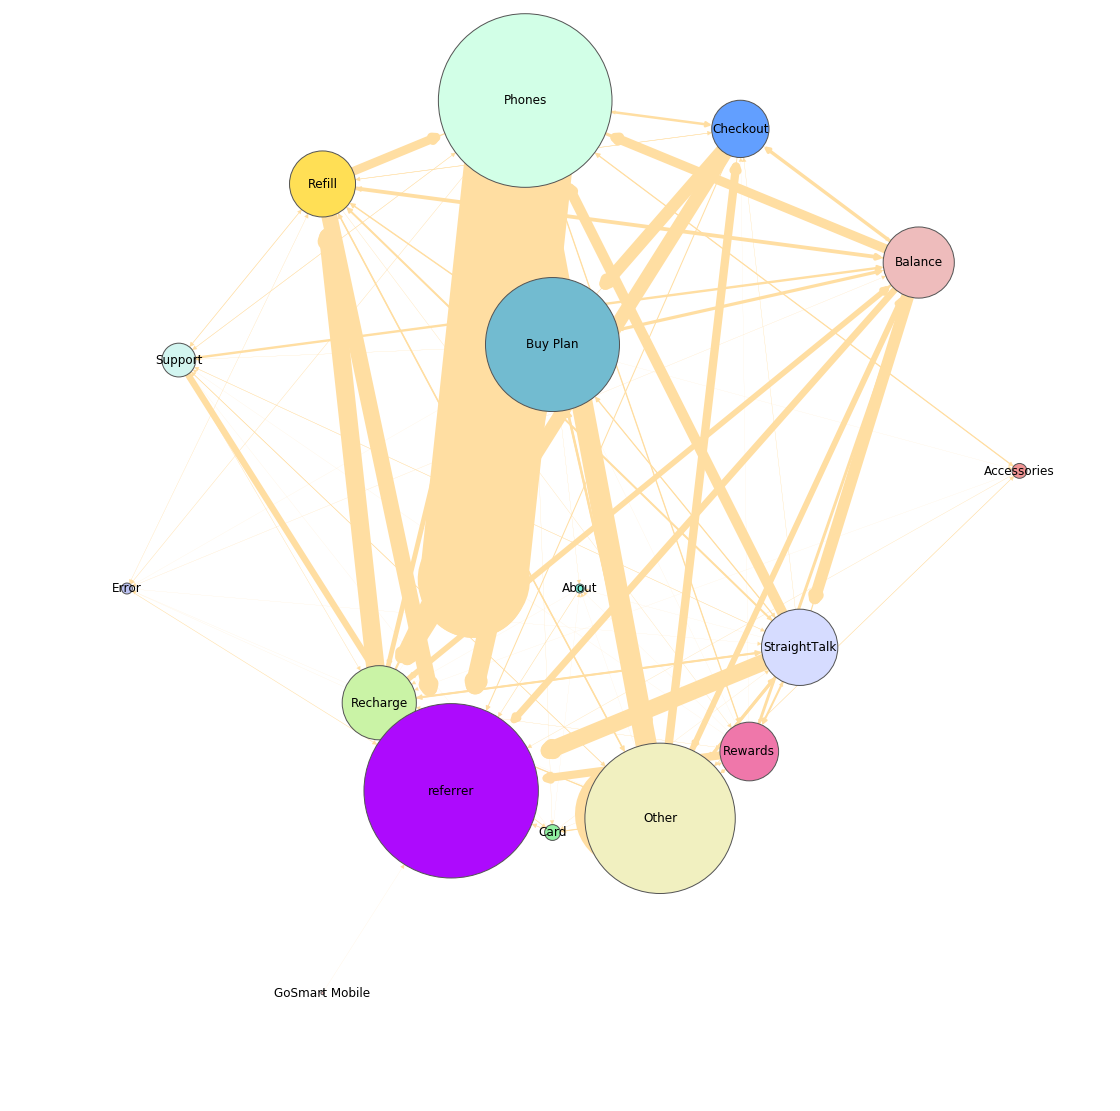

In [6]:
#https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
color_map = {0: '#7bf2da', 1: '#f09494', 2: '#eebcbc', 3: '#72bbd0', 4: '#91f0a1', 5: '#629fff', 6: '#bcc2f2',
             7: '#eebcbc', 8: '#f1f0c0', 9: '#d2ffe7', 10: '#caf3a6', 11: '#ffdf55', 12: '#ef77aa',
             13: '#d6dcff', 14: '#d2f5f0', 15: '#ad0afd'}

plt.figure(figsize=(15, 15))

colors = [color_map[G.nodes[node]['group']] for node in G]
sizes = [G.nodes[node]['nodesize'] * 10 for node in G]
edges = G.edges()
weights = [G[u][v]['weight']/10 for u,v in edges]
options = {
       'edge_color': '#FFDEA2',
       'width': weights,
       'with_labels': True,
       'font_weight': 'regular'}
nx.draw(G, node_color=colors, node_size=sizes, pos= graphviz_layout(G, prog='twopi', args=''), **options)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555")
plt.savefig('test.pdf')
plt.show()